# Andromeda in Jupyter

### Interactive Inverse Dimension Reduction 

This notebook implements interactive dimension reduction (DR) for exploratory analysis of high-dimensional data.
It uses a Multi-Dimensional Scaling (MDS) algorithm with a weighted distance metric. It enables both forward and inverse DR interaction. 

**MDS** projects high-dimensional data to a 2D scatterplot. A **weighted distance function** with user-specified weights on each dimension enables alternative projections that emphasize different dimensions. An **Inverse-DR** algorithm learns distance function weights for  user-constructed layouts of the data points.

### Instructions:

1. Run All
1. Proceed to the interactive plots near the bottom
1. There are three kinds of interactions:
    1. Select points in the DR plot and click Details to see data values.
    1. **Parametric interaction:** Adjust the weight sliders and click Apply to alter the projection plot.
    1. **Projection interaction:** Drag points in the projection plot, then click Learn to see learned weights, and click Copy to see the updated projection plot.
1. Be patient, its interactive matplotlib in python and Jupyter!

### Credits:

Authors: Han Liu and Chris North, Dept of Computer Science, Virginia Tech.

Based on: *Self JZ, Dowling M, Wenskovitch J, Crandell I, Wang M, House L, Leman S, North C. Observation-Level and Parametric Interaction for High-Dimensional Data Analysis. ACM Transactions on Interactive Intelligent Systems.  8(2), 2018.* https://infovis.cs.vt.edu/sites/default/files/observation-level-parametric_first_look_version.pdf


In [1]:
%matplotlib notebook
# interactive notebook format is required for the interactive plot

import numpy as np
import pandas as pd
import math
import random

from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import sklearn.metrics.pairwise

import matplotlib
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Load and Pre-process Data

Change the **filename** to load a dataset.  CSV data file is expected to have a first column 'Name' that is used as the index, and header row of column names.  Numeric columns are used for projection.

In [2]:
! ls 

ColorHist_Andromeda.ipynb     DNN_Andromeda.ipynb
DNN_Andromeda-disease.ipynb   OppSift_Andromeda.ipynb
DNN_Andromeda-lateReady.ipynb Sift_Andromeda.ipynb


In [3]:
# filename = 'Animal_Data_Andromeda.csv'
#filename = 'InfoVis_Fall_2015_Survey.csv'
filename = '../csvFiles/OppoSiftFeatures_batch5.csv'
df = pd.read_csv(filename)
# df['Image'] = df['Image'].apply(lambda x: x.split('_')[2]+ x.split('_')[-2]+x.split('_')[-1])

In [4]:
display(df.shape)
df.head(5)

(60, 65)

,Image,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,2098late4,0.021563,0.010908,0.003805,0.021055,0.004566,0.019533,0.005835,0.015728,0.018519,...,0.014967,0.006342,0.001015,0.025368,0.000000,0.015728,0.017757,0.020548,0.015221,0.016489
1,2076late6,0.018315,0.011842,0.003029,0.011016,0.005095,0.013357,0.004544,0.022859,0.019278,...,0.013357,0.003718,0.001652,0.027954,0.002066,0.024373,0.019554,0.024511,0.023547,0.021069
2,2144disease7,0.008608,0.033477,0.005739,0.022956,0.001913,0.016738,0.024390,0.009565,0.005739,...,0.041607,0.015304,0.003826,0.009087,0.042085,0.004304,0.009087,0.005261,0.001913,0.007652
3,2076late5,0.018335,0.011787,0.004948,0.011641,0.007712,0.021682,0.005966,0.021682,0.015570,...,0.010477,0.004220,0.001892,0.021682,0.001601,0.020373,0.024738,0.020081,0.019790,0.017608
4,2044ready5,0.019162,0.003248,0.014290,0.012666,0.000974,0.015265,0.008769,0.024034,0.015914,...,0.004547,0.006496,0.004547,0.018837,0.001299,0.026632,0.016564,0.019812,0.014940,0.012342


In [5]:
# Use 'Name' column as index
#df.rename(columns={df.columns[0]:'Name'}, inplace=True)
df.set_index('Image', inplace=True)

# Sort rows and columns
# df.sort_index(axis=1, inplace=True)
df.sort_index(inplace=True)

df_numeric = df.select_dtypes(include='number')  #'int32' or 'int64' or 'float32' or 'float64'
df_category = df.select_dtypes(exclude='number') #'object'

# Z-score normalization
# normalized_df = (df_numeric - df_numeric.mean()) / df_numeric.std()
normalized_df = df_numeric  # do not normalize animal dataset, all columns are 0-100 scale

print('Data size (r,c) =', df_numeric.shape)
df_numeric.head(5)

Data size (r,c) = (60, 64)


,1,2,3,4,5,6,7,8,9,10,...,55,56,57,58,59,60,61,62,63,64
Image,,,,,,,,,,,,,,,,,,,,,
2024ready2,0.018459,0.004260,0.011360,0.018104,0.003195,0.029109,0.014554,0.011005,0.015264,0.006390,...,0.006035,0.012425,0.012780,0.011005,0.000355,0.010650,0.020234,0.011715,0.011715,0.017394
2028ready4,0.015136,0.002073,0.038980,0.012440,0.002073,0.009123,0.013062,0.017831,0.010989,0.002073,...,0.003110,0.007672,0.026954,0.019075,0.005183,0.022600,0.013062,0.015758,0.010160,0.012855
2029ready20,0.015863,0.006217,0.014362,0.011790,0.003215,0.012219,0.010075,0.016506,0.019078,0.006217,...,0.006217,0.008789,0.008789,0.022294,0.001715,0.021865,0.015648,0.018864,0.015434,0.016935
2031ready1,0.018903,0.003346,0.007528,0.010539,0.002509,0.011542,0.006357,0.030445,0.017732,0.002676,...,0.003680,0.004517,0.008029,0.033456,0.000836,0.027434,0.017230,0.024925,0.022750,0.014721
2033ready9,0.020528,0.004888,0.010020,0.008553,0.002688,0.022239,0.009531,0.017840,0.019306,0.003421,...,0.004154,0.008553,0.012219,0.020528,0.002444,0.015885,0.016373,0.013930,0.013196,0.015152


#  Dimension Reduction Model:  Weighted MDS

For DR, we use the Multi-Dimensional Scaling (MDS) algorithm on a weighted data space. **Dimension weights** are applied to the high-dimensional (HD) data.  Weights are normalized to sum to 1, so as to normalize the HD distances to roughly constant size space independent of p.

The **distance function for the high-dimensional (HD) data** is L1 manhattan distance. L1 is good for general purpose use with multi-dimensional quantitative datasets. 

The **distance function for the 2D projected points** is L2 Euclidean distance, which makes sense for human percpetion in the plot.

In [6]:
# Compute the distance matrix for the weighted high-dimensional data using L1 distance function.
#  Input HD data should already be weighted.
def distance_matrix_HD(dataHDw):  # dataHDw (pandas or numpy) -> distance matrix (numpy)
    dist_matrix = sklearn.metrics.pairwise.manhattan_distances(dataHDw)
    #m = pd.DataFrame(m, columns=dataHD.index, index=dataHD.index)  # keep as np array for performance
    return dist_matrix

# Compute the distance matrix for 2D projected data using L2 distance function.
def distance_matrix_2D(data2D):  # data2d (pandas or numpy) -> distance matrix (numpy)
    dist_matrix = sklearn.metrics.pairwise.euclidean_distances(data2D) 
    #m = pd.DataFrame(m, columns=data2D.index, index=data2D.index) # keep as np array for performance
    return dist_matrix

#def dist(x,y):
#    return np.linalg.norm(x-y, ord=2)

**MDS** projects the weighted high-dimensional data to 2D. Tune the algorithm's parameters for performance.

In [7]:
# Calculate the MDS stress metric between HD and 2D distances.  Uses numpy for efficiency.
def stress(distHD, dist2D):  #  distHD, dist2D (numpy) -> stress (float)
    #s = np.sqrt((distHD-dist2D).pow(2).sum().sum() / distHD.pow(2).sum().sum())  # pandas
    #s = np.sqrt(((distHD-dist2D)**2).sum() / (distHD**2).sum())   # numpy
    s = ((distHD-dist2D)**2).sum() / (distHD**2).sum()   # numpy, eliminate sqrt for efficiency
    return s

def compute_mds(dataHDw):  # dataHDw -> data2D (pandas)
    distHD = distance_matrix_HD(dataHDw)
    # Adjust these parameters for performance/accuracy tradeoff
    mds = sklearn.manifold.MDS(n_components=2, dissimilarity='precomputed', n_init=10, max_iter=1000)
    # Reduction algorithm happens here:  data2D is nx2 matrix
    data2D = mds.fit_transform(distHD)
    
    # Rotate the resulting 2D projection to make it more consistent across multiple runs.
    # Set the 1st PC to the y axis, plot looks better to spread data vertically with horizontal text labels
    pca = sklearn.decomposition.PCA(n_components=2)
    data2D = pca.fit_transform(data2D)
    data2D = pd.DataFrame(data2D, columns=['y','x'], index=dataHDw.index)
    
    data2D.stress_value = stress(distHD, distance_matrix_2D(data2D))
    return data2D

def dimension_reduction(dataHD, wts): # dataHD, wts -> data2D (pandas)
    # Normalize the weights to sum to 1
    wts = wts/wts.sum()
    
    # Apply weights to the HD data 
    dataHDw = dataHD * wts
    
    # DR algorithm
    data2D = compute_mds(dataHDw)

    # Compute row relevances as:  data dot weights
    # High relevance means large values in upweighted dimensions
    data2D['relevance'] = dataHDw.sum(axis=1)
    return data2D


min_weight, max_weight = 0.00001, 0.9999
init_weight = min_weight  # 1.0/len(normalized_df.columns) # initialize to min to make the sliders easier to use.
weights = pd.Series(init_weight, index=normalized_df.columns, name="Weight")  # the current weight list

df_2D = dimension_reduction(normalized_df, weights)   # the current projected data

In [8]:
weights.head(2)

1    0.00001
2    0.00001
Name: Weight, dtype: float64

In [9]:
pd.DataFrame(distance_matrix_HD(normalized_df * (weights/weights.sum())), 
             columns=normalized_df.index, index=normalized_df.index).head(2)

Image,2024ready2,2028ready4,2029ready20,2031ready1,2033ready9,2034ready5,2036ready18,2038ready15,2038ready3,2039ready12,...,2147disease15,2147disease2,2147disease4,2147disease5,2147disease6,2147disease7,2148disease11,2148disease12,2148disease13,2148disease17
Image,,,,,,,,,,,,,,,,,,,,,
2024ready2,0.00000,0.00747,0.005470,0.007027,0.004327,0.005141,0.006532,0.005383,0.005771,0.005993,...,0.010087,0.007979,0.011489,0.010935,0.011735,0.007408,0.013341,0.005580,0.007071,0.006586
2028ready4,0.00747,0.00000,0.004501,0.006786,0.006010,0.006115,0.006713,0.007773,0.007342,0.007029,...,0.014326,0.010439,0.015781,0.013379,0.014949,0.011916,0.017335,0.009778,0.010990,0.010895


In [10]:
print(df_2D.stress_value)
df_2D.head(2)

0.0364663713500289


,y,x,relevance
Image,,,
2024ready2,0.000124,0.003324,0.015625
2028ready4,-0.004956,0.006101,0.015625


# Inverse Dimension-Reduction Learning Algorithm

Computes the inverse-Dimension-Reduction: given input 2D points, compute new weights.
Optimizes the MDS stress function that compares 2D pairwise distances (||$x_i-x_j||$) to weighted HD pairwise distances ($d_{ij}$):
![Stress](https://wikimedia.org/api/rest_v1/media/math/render/svg/7989b3afc0d8795a78c1631c7e807f260d9cfe68)

Technically, we compute the inverse weighted distance function. We shortcut the optimization by eliminating MDS from the process, and assume that the user input 2D distances are actually the desired HD distances, not the 2D distances after re-projection. Thus, given the input (HD) distances, we find weights that would produce these distances in the HD space.

In [11]:
# This method is used to propose a new weight for current column in a smart fashion
def new_proposal(current, step, direction):
    return np.clip(current + direction*step*random.random(), 0.00001, 0.9999)

# Repeatedly tries to modify each dim weight to see if it improves the stress, thus
# getting the weighted high-dim distances to more closely match the input 2D distances.
#   dataHD = high-dim data, as pandas
#   data2D = 2D data input, as pandas
#   weights = as pandas series, or None for weights[i]=1/p
def inverse_DR(dataHD, data2D, curWeights=None):  # -> new weights, as Series
    dist2D = distance_matrix_2D(data2D)  # compute 2D distances only once
    col_names = dataHD.columns
    dataHD = dataHD.to_numpy()  # use numpy for efficiency
    row, col = dataHD.shape
    
    if curWeights==None:
        curWeights = np.array([1.0/col]*col)  # default weights = 1/p
    else:
        curWeights = curWeights.to_numpy()
        curWeights = curWeights / curWeights.sum()  # Normalize weights to sum to 1
    newWeights = curWeights.copy()  # re-use this array for efficiency
    
    # Initialize state
    flag = [0]*col         # degree of success of a weight change
    direction = [1]*col  # direction to move a weight, pos or neg
    step = [1.0/col]*col   # how much to change each weight
    
    dataHDw = dataHD * curWeights   # weighted space, re-use this array for efficiency
    distHD = distance_matrix_HD(dataHDw)
    curStress = stress(distHD, dist2D)
    print('Starting stress =', curStress, 'Processing...')

    MAX = 500   # default setting of the number of iterations

    # Try to minorly adjust each weight to see if it reduces stress
    for i in range(MAX):
        for dim in range(col):            
            # Get a new weight for current column
            nw = new_proposal(curWeights[dim], step[dim], direction[dim])
            
            # Scale the weight list such that it sums to 1
            #newWeights = curWeights.copy()  # avoid extra copy op using math below
            #newWeights[dim] = nw
            #newWeights = newWeights / s
            s = 1.0  + nw - curWeights[dim]   # 1.0 == curWeights.sum()
            np.true_divide(curWeights, s, out=newWeights)  # transfers to other array, while doing /
            newWeights[dim] = nw / s
            
            # Apply new weights to HD data
            np.multiply(dataHD, newWeights, out=dataHDw)  # dataHDw = dataHD * newWeights; efficiently reuses dataHDw array
            distHD = distance_matrix_HD(dataHDw)

            # Get the new stress
            newStress = stress(distHD, dist2D)
            
            # If new stress is lower, then update weights and flag this success
            if newStress < curStress:
                temp = curWeights
                curWeights = newWeights
                newWeights = temp   # reuse the old array next iteration
                curStress = newStress
                flag[dim] = flag[dim] + 1
            else:
                flag[dim] = flag[dim] - 1
                direction[dim] = -direction[dim]  # Reverse course
    
            # If recent success, then speed up the step rate
            if flag[dim] >= 5:
                step[dim] = step[dim] * 2
                flag[dim] = 0
            elif flag[dim] <= -5:
                step[dim] = step[dim] / 2
                flag[dim] = 0
                
    print('Solution stress =', curStress, 'Done.')
    #print("weight", curWeights)
    #print("flag", flag)
    #print("dir", direction)
    #print("step", step)
    return pd.Series(curWeights, index=col_names, name="Weight")


# Visualization and UI code

Use these functions to create the GUI components in any cell.

## Sliders

In [12]:
def create_sliders(wts):
    # Create sliders, one for each dimension weight
    sliders = [widgets.FloatSlider(min=min_weight, max=max_weight, step=0.01, value=value, 
                                       description=label, continuous_update=False, readout_format='.5f')
                   for (label, value) in wts.iteritems()]
    # Display sliders
    for s in sliders:
        #s.observe(sliderchange, names='value')
        display(s)
        
    create_slider_buttons(sliders)
    return sliders

def create_slider_buttons(sliders):    
    apply_button = widgets.Button(description='Apply Slider Weights')
    reset_button = widgets.Button(description='Reset Plot')

    # Callback functions
    def apply_button_clicked(change):
        # Use the slider values to re compute the DR and redraw the plot
        global weights, df_2D   # Update weights and df_2D globals
        weights = pd.Series([s.value for s in sliders], index=normalized_df.columns, name='Weight')
        df_2D = dimension_reduction(normalized_df, weights)   
        
        # Re-draw the plot
        draw_plot(plot_ax, df_2D)
    apply_button.on_click(apply_button_clicked)

    def reset_button_clicked(change):
        # Reset all sliders to initial value and re-compute DR and re-draw the plot
        for s in sliders:
            s.value = init_weight
        apply_button_clicked(change)
    reset_button.on_click(reset_button_clicked)
    
    # Display buttons
    display(apply_button)
    display(reset_button)
    return apply_button, reset_button


## Print Details Button

In [13]:
def create_detail_display():
    # Print selected points
    print_button = widgets.Button(description='Print selected points')
    print_output = widgets.Output()

    def print_button_clicked(change):
        print_output.clear_output()
        # Get list of selected points and print their source data values
        selset = [c.index for c in plot_ax.circles if c.selected]
        with print_output:
            if len(selset) > 0:
                print(df.iloc[selset, :].transpose())
            else:
                print('Select points in the plot to see details here')
    print_button.on_click(print_button_clicked)

    display(print_button)
    display(print_output)
    return print_button, print_output


## Inverse DR Button and Plot

In [14]:
def create_inverse_button():
    inverse_button = widgets.Button(description='Learn New Weights')
    copy_button = widgets.Button(description='Copy to Sliders')

    def inverse_button_clicked(change):
        ax.clear()

        # Check minimum number of points moved
        n = len([1 for c in plot_ax.circles if c.selected])
        if n < 2:
            print('Need to select or move at least 2 points in the plot first.')
            return

        # Get selected data points
        data2Dnew = pd.DataFrame([c.center for c in plot_ax.circles if c.selected], columns=['x','y'], 
                                index=[c.label for c in plot_ax.circles if c.selected])
        dataHDpart = normalized_df.loc[data2Dnew.index]

        # Learn new weights
        global weights
        weights = inverse_DR(dataHDpart, data2Dnew)
        
        # Display new weights as a bar chart
        weights.sort_index(ascending=False).plot.barh(ax=ax)
        ax.set_xlabel("Weight")
        fig.tight_layout()
    inverse_button.on_click(inverse_button_clicked)

    def copy_button_clicked(change):
        # Set sliders to reflect the learned weights and update the DR and plot accordingly
        global df_2D
        for i,s in enumerate(sliders):
            s.value = weights[i]
        df_2D = dimension_reduction(normalized_df, weights)   
        draw_plot(plot_ax, df_2D)
    copy_button.on_click(copy_button_clicked)
    display(inverse_button)
    display(copy_button)
    fig, ax = plt.subplots(figsize=(5,7))   # reserve a fig for the weights bar chart
    return inverse_button, copy_button, ax


## Draggable Dimension-Reduction 2D Plot

In [15]:
# Handles mouse drag interaction events in the plot, users can select and drag points.
class DraggablePoints(object):
    def __init__(self, ax, artists):
        self.ax = ax
        self.artists = artists
        self.current_artist = None
        self.last_selected = None
        ax.selected_text.set_text('Selected: none')
        self.offset = (0, 0)
        # Set up mouse listeners
        ax.figure.canvas.mpl_connect('pick_event', self.on_pick)
        ax.figure.canvas.mpl_connect('motion_notify_event', self.on_motion)
        ax.figure.canvas.mpl_connect('button_release_event', self.on_release)

    def on_pick(self, event):
        # When point is clicked on (mouse down), select it and start the drag
        if self.current_artist is None:  # clicking on overlapped points sends multiple events
            self.last_selected = event.artist.index  # event.ind
            self.current_artist = event.artist
            event.artist.selected = True
            event.artist.savecolor = event.artist.get_facecolor()
            event.artist.set_facecolor('green')
            #event.artist.set_alpha(1.0)
            self.ax.selected_text.set_text("Selected: " + event.artist.label)
            x0, y0 = event.artist.center
            self.offset = (x0 - event.mouseevent.xdata), (y0 - event.mouseevent.ydata)

    def on_motion(self, event):
        # When dragging, check if point is selected and valid mouse coordinates
        if (self.current_artist is not None) and (event.xdata is not None) and (event.ydata is not None):
            # Drag the point and its text label
            dx, dy = self.offset
            self.current_artist.center = x0, y0 = event.xdata + dx, event.ydata + dy
            self.current_artist.text.set_position((x0 - self.current_artist.radius/2, 
                                                   y0 - self.current_artist.radius/2))
            #self.ax.figure.canvas.draw()  # slow
        
    def on_release(self, event):
        # When mouse is released, stop the drag
        self.current_artist = None
        #self.ax.figure.canvas.draw()

In [16]:
def create_plot(data2D):
    # Initialize DR plot figure
    fig, ax = plt.subplots(figsize= (8,7))
    ax.selected_text = ax.figure.text(0,0.005, 'Selected: none', wrap=True, color='green')
    fig.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(), cmap=plt.cm.plasma), ax=ax, label="Relevance", ticks=[], shrink=0.5, aspect=40, fraction=0.05)
    # ax = data2D.plot.scatter(x="x", y="y", alpha=0.5, c="relevance", s=75, ax=ax
    #                   colormap=plt.cm.plasma, sharex=False, figsize=(8, 6), picker=True)
    # ax.collections[0].get_offsets());   set_offsets(data2D[['y','x']]);   .get_facecolors()
    
    # Clean up the plot
    ax.set_xticks([])
    ax.set_yticks([])
    ax.figure.tight_layout()
    #plt.show()
    
    # Store state data:
    ax.circles = None
    ax.dragpoint = None
    
    draw_plot(ax, data2D)
    return ax

def draw_plot(ax, data2D):
    # Re-draws the DR plot in the axes with the updated data2D
    ax.clear()
    # Map data to circles, with x, y, and relevance->color
    wid = max(data2D.x.max() - data2D.x.min(), data2D.y.max() - data2D.y.min())  # max range of x,y axes
    cnorm = matplotlib.colors.Normalize(vmin=data2D.relevance.min(), vmax=data2D.relevance.max())
    ax.circles = data2D.apply(axis=1, func=lambda row: 
        matplotlib.patches.Circle(xy=(row.x, row.y), radius=wid/70, alpha=0.5, 
                                  color=plt.cm.plasma(cnorm(row.relevance)), picker=True))
    for i,c in enumerate(ax.circles):
        # Store state data:
        c.index, c.label, c.selected = i, data2D.index[i], False
        # Draw circles and text labels in plot
        ax.add_patch(c)
        c.text = ax.text(c.center[0]-c.radius/2, c.center[1]-c.radius/2, c.label)
    # Make plot circles draggable
    ax.dragpoint = DraggablePoints(ax, ax.circles)
    
    # Clean up the plot
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('equal')
    #plt.show()


# Interactive Visualization

## Sliders
Use the sliders to control the **dimension weights** for the input HD data. The weights indicate which dimensions are given more emphasis in the DR plot distances.  For computational reasons, weights cannot go to absolute zero. When used in DR, the weights are first normalized such that they sum to 1.

After adjusting the sliders, click the **Apply** button to show the results in the DR plot.

To reset the sliders to their default values, click the **Reset** button.

In [17]:
sliders = create_sliders(weights)

FloatSlider(value=1e-05, continuous_update=False, description='1', max=0.9999, min=1e-05, readout_format='.5f'…

FloatSlider(value=1e-05, continuous_update=False, description='2', max=0.9999, min=1e-05, readout_format='.5f'…

FloatSlider(value=1e-05, continuous_update=False, description='3', max=0.9999, min=1e-05, readout_format='.5f'…

FloatSlider(value=1e-05, continuous_update=False, description='4', max=0.9999, min=1e-05, readout_format='.5f'…

FloatSlider(value=1e-05, continuous_update=False, description='5', max=0.9999, min=1e-05, readout_format='.5f'…

FloatSlider(value=1e-05, continuous_update=False, description='6', max=0.9999, min=1e-05, readout_format='.5f'…

FloatSlider(value=1e-05, continuous_update=False, description='7', max=0.9999, min=1e-05, readout_format='.5f'…

FloatSlider(value=1e-05, continuous_update=False, description='8', max=0.9999, min=1e-05, readout_format='.5f'…

FloatSlider(value=1e-05, continuous_update=False, description='9', max=0.9999, min=1e-05, readout_format='.5f'…

FloatSlider(value=1e-05, continuous_update=False, description='10', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='11', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='12', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='13', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='14', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='15', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='16', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='17', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='18', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='19', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='20', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='21', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='22', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='23', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='24', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='25', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='26', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='27', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='28', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='29', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='30', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='31', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='32', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='33', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='34', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='35', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='36', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='37', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='38', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='39', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='40', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='41', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='42', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='43', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='44', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='45', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='46', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='47', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='48', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='49', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='50', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='51', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='52', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='53', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='54', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='55', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='56', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='57', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='58', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='59', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='60', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='61', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='62', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='63', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='64', max=0.9999, min=1e-05, readout_format='.5f…

Button(description='Apply Slider Weights', style=ButtonStyle())

Button(description='Reset Plot', style=ButtonStyle())

## Dimension Reduction Plot
This shows the HD data in 2D form, such that **proximity == similarity**, based on the current slider weights.  Distances between points in the plot approximately reflect their distances in the weighted HD data.  Thus points near each other have similar HD data values in the up-weighted dimensions, and points far away have very different HD data values in those dimensions.

The color represents the **relevance** of each point to the current slider weights. Yellower points have larger values in up-weighted dimensions.

Points can be **selected** to highlight in Green and view their details below.  Points can be **dragged** to specify a new projection for learning weights, see below. To reset the plot and clear the selections, click the **Reset** button above.

<IPython.core.display.Javascript object>


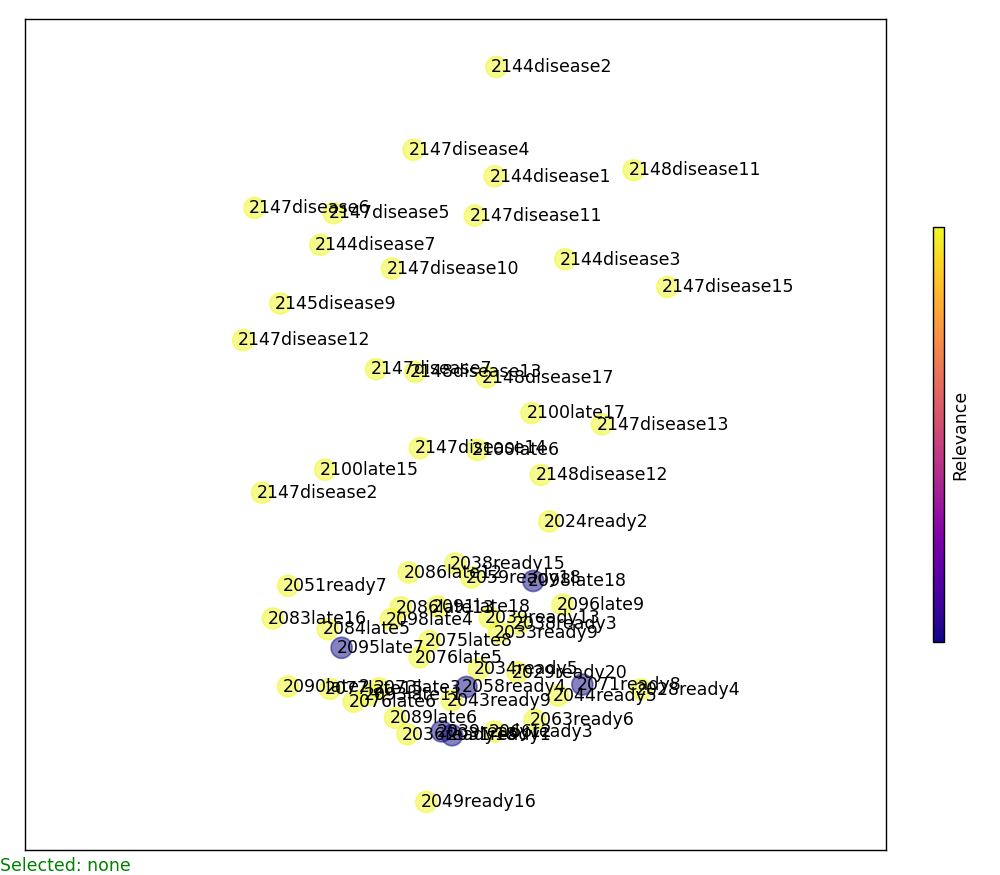

In [18]:
plot_ax = create_plot(df_2D)

##  Selected Points Details
Click the **Print** button below to display detailed data values of the points selected in the DR plot.  The selected points are Green.

In [19]:
dod = create_detail_display()

Button(description='Print selected points', style=ButtonStyle())

Output()

## Inverse Dimension Reduction
After selecting and/or dragging some points in the DR plot, click the **Learn** button to machine learn new dimension weights that would produce a plot with similar pairwise distances as your plot.  **Only the Green selected points** in the plot are considered when learning new weights. You must select or move at least two points to specify new desired distances. Use this to create your own clusters, and find out what makes some data points similar to or different from others.  The **learned weights** are shown in a bar chart below.

To see the effects of the learned weights, click the **Copy** button to apply the learned weights to the sliders and  make a new DR plot above.

Button(description='Learn New Weights', style=ButtonStyle())

Button(description='Copy to Sliders', style=ButtonStyle())

<IPython.core.display.Javascript object>


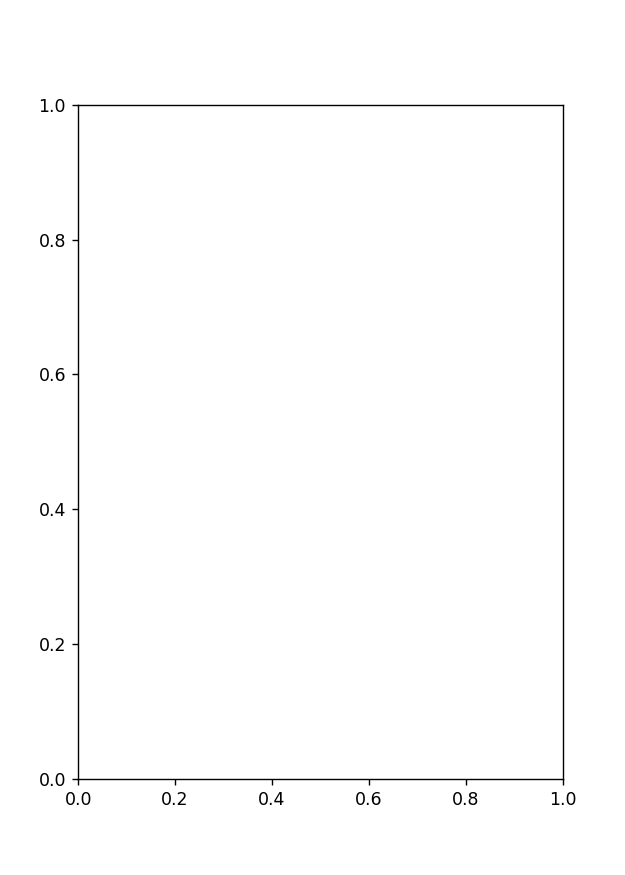

In [20]:
inverse = create_inverse_button()

In [21]:
! rm ./testTrainingData/.DS_Store

rm: ./testTrainingData/.DS_Store: No such file or directory
